In [1]:
# Standard imports
import numpy as np
import pandas as pd
import time
from pathlib import Path

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical imports
from scipy import stats
from scipy.optimize import minimize

# Machine learning imports
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Data imbalance handling
from imblearn.over_sampling import SMOTE

# H2O imports for advanced models
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, H2ORandomForestEstimator

# Hyperparameter tuning
import optuna


# Configuration settings
pd.set_option('display.max_columns', None)

# Constants
RANDOM_SEED = 42
TEST_SIZE = 0.2
COLORS = {
    'primary': 'darkblue',
    'secondary': 'darkgreen',
    'tertiary': 'darkred'
}

# File paths
DATA_PATH = Path('/kaggle/input/exploring-predictive-health-factors')
ORIG_DATA_PATH = Path('/kaggle/input/diet-exercise-and-pcos-insights')

In [2]:
def load_data():
    """Load and return training, test, and original datasets."""
    df_train = pd.read_csv(DATA_PATH / 'train.csv', low_memory=False)
    df_test = pd.read_csv(DATA_PATH / 'test.csv', low_memory=False)
    df_submission = pd.read_csv(DATA_PATH / 'sample_submission.csv')
    df_original = pd.read_csv(ORIG_DATA_PATH / 'Cleaned-Data.csv')
    
    return df_train, df_test, df_submission, df_original

def define_features():
    """Define and return feature sets and target variable."""
    features_numeric = ['Weight_kg']
    
    features_categorical = [
        'Age', 'Hormonal_Imbalance', 'Hyperandrogenism', 'Hirsutism',
        'Conception_Difficulty', 'Insulin_Resistance', 'Exercise_Frequency',
        'Exercise_Type', 'Exercise_Duration', 'Sleep_Hours', 'Exercise_Benefit'
    ]
    
    target = 'PCOS'
    
    return features_numeric, features_categorical, target

def process_age_groups(df, is_train=True):
    """Process and categorize age groups in the dataset."""
    df['Age_Group'] = 'MISSING'
    
    # Define age mappings
    age_mappings = {
        'lt20': ['15-20', 'Less than 20', 'Less than 20-25', 'Less than 20)'],
        '20-25': ['20-25', '20', '22-25', '25-25'],
        'gt25': [
            '25-30', '30-35', '30-25', '30-40', '35-44',
            '45 and above', '30-30', '50-60', '45-49'
        ]
    }
    
    # Apply mappings
    for group, values in age_mappings.items():
        df.loc[df['Age'].isin(values), 'Age_Group'] = group

    df = df.drop(columns=['Age'])
    return df

def process_exercise_types(df, is_train=True):
    """Process and categorize exercise types in the dataset."""
    df['Exercise_Type_Clean'] = 'MISSING'
    
    exercise_mappings = {
        'No Exercise': ['No Exercise', 'No'],
        'Cardio': ['Cardio (e.g.', 'Cardio (e.g., running, cycling, swimming)'],
        'Flexibility': ['Flexibility and balance (e.g.', 'Flexibility and balance (e.g., yoga, pilates)'],
        'Strength': ['Strength training', 'Strength training (e.g.'],
        'Somewhat': ['Somewhat'],
        'Other': ['Yes Significantly']
    }
    
    # Apply mappings
    for category, values in exercise_mappings.items():
        df.loc[df['Exercise_Type'].isin(values), 'Exercise_Type_Clean'] = category

    df = df.drop(columns=['Exercise_Type'])
    return df

## TRANSFORM DATASET TRAIN AND TEST
Taking care of missing values, outlier, etc. 

In [3]:
def check_missing_values(df, name="dataset"):
    """Check and display missing values information."""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    
    print(f"\nMissing Values in {name}:")
    print(missing_info[missing_info['Missing Values'] > 0])
    
    return missing_info

def check_duplicates(df, name="dataset"):
    """Check and display duplicate records information."""
    n_duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate records in {name}: {n_duplicates}")
    return n_duplicates

def plot_boxplots(df, numeric_cols):
    """Plot boxplots for numeric columns to identify outliers."""
    plt.figure(figsize=(12, 4 * (len(numeric_cols) // 2 + 1)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols) // 2 + 1, 2, i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

def handle_outliers(df, numeric_cols, method='iqr'):
    """
    Handle outliers in numeric columns.
    method: 'iqr' for IQR method or 'zscore' for Z-score method
    """
    df_clean = df.copy()
    
    for col in numeric_cols:
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Replace outliers with bounds
            df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
            
        elif method == 'zscore':
            z_scores = stats.zscore(df[col])
            abs_z_scores = np.abs(z_scores)
            filtered_entries = (abs_z_scores < 3)
            
            # Replace outliers with median
            median_value = df[col].median()
            df_clean.loc[~filtered_entries, col] = median_value
    
    return df_clean

def encode_categorical_variables(df_train, df_test, categorical_cols):
    """
    Encode categorical variables using LabelEncoder.
    Ensures consistent encoding between train and test sets.
    """
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()
    encoders = {}
    
    for col in categorical_cols:
        # Create and fit encoder on training data
        encoder = LabelEncoder()
        df_train_encoded[col] = encoder.fit_transform(df_train[col])
        
        # Transform test data using the same encoder
        # Handle unseen categories in test set
        unique_test_values = df_test[col].unique()
        unique_train_values = encoder.classes_
        unseen_values = set(unique_test_values) - set(unique_train_values)
        
        if len(unseen_values) > 0:
            print(f"Warning: Unseen categories in {col}: {unseen_values}")
            # Handle unseen values by mapping them to the most frequent category
            mode_category = df_train[col].mode()[0]
            df_test_encoded[col] = df_test[col].replace(list(unseen_values), mode_category)
        
        df_test_encoded[col] = encoder.transform(df_test_encoded[col])
        encoders[col] = encoder
    
    return df_train_encoded, df_test_encoded, encoders

def prepare_data_for_modeling(df_train, df_test):
    """Execute complete data preparation pipeline."""
    
    # Define column types
    numeric_cols = ['Weight_kg']
    categorical_cols = [
        'Age_Group', 'Exercise_Type_Clean', 'Hormonal_Imbalance',
        'Hyperandrogenism', 'Hirsutism', 'Conception_Difficulty',
        'Insulin_Resistance', 'Exercise_Frequency', 'Exercise_Duration',
        'Sleep_Hours', 'Exercise_Benefit'
    ]
    
    # Check data quality
    print("Initial Data Quality Check:")
    check_missing_values(df_train, "Training Set")
    check_missing_values(df_test, "Test Set")
    check_duplicates(df_train, "Training Set")
    check_duplicates(df_test, "Test Set")
    
    # Plot distributions and boxplots for numeric variables
    plot_boxplots(df_train, numeric_cols)
    
    # Handle outliers
    df_train_clean = handle_outliers(df_train, numeric_cols, method='iqr')
    df_test_clean = handle_outliers(df_test, numeric_cols, method='iqr')
    
    # # Handle missing values
    # for col in numeric_cols:
    #     df_train_clean[col].fillna(df_train_clean[col].median(), inplace=True)
    #     df_test_clean[col].fillna(df_train_clean[col].median(), inplace=True)

    # Handle missing values with IterativeImputer for numeric data
    imputer = IterativeImputer(random_state=42)
    df_train_clean[numeric_cols] = imputer.fit_transform(df_train_clean[numeric_cols])
    df_test_clean[numeric_cols] = imputer.transform(df_test_clean[numeric_cols])
    
    for col in categorical_cols:
        df_train_clean[col].fillna(df_train_clean[col].mode()[0], inplace=True)
        df_test_clean[col].fillna(df_train_clean[col].mode()[0], inplace=True)
    
    # Encode categorical variables
    df_train_prepared, df_test_prepared, encoders = encode_categorical_variables(
        df_train_clean,
        df_test_clean,
        categorical_cols
    )
    
    return df_train_prepared, df_test_prepared, encoders

# DATA IMBALANCE OF THE TARGET

In [4]:
def plot_class_distribution(y, title):
    """Plot the distribution of classes."""
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y)
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('PCOS')
    plt.ylabel('Count')
    
    # Add count labels on top of bars
    for i, count in enumerate(Counter(y).values()):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    plt.show()

def apply_smote(X, y, random_state=42):
    """
    Apply SMOTE to balance the dataset.
    
    Parameters:
        X: Features DataFrame
        y: Target Series
        random_state: Random seed for reproducibility
    
    Returns:
        X_resampled: Balanced features DataFrame
        y_resampled: Balanced target Series
    """
    # Initialize SMOTE
    smote = SMOTE(random_state=random_state)
    
    # Fit and apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Convert to DataFrame/Series to maintain column names
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled = pd.Series(y_resampled, name=y.name)
    
    return X_resampled, y_resampled

def balance_and_split_data(df_train_prepared, target_column='PCOS', test_size=0.2, random_state=42):
    """
    Balance the dataset using SMOTE and split into train/validation sets.
    
    Parameters:
        df_train_prepared: Prepared training DataFrame
        target_column: Name of the target column
        test_size: Proportion of validation set
        random_state: Random seed for reproducibility
    
    Returns:
        X_train: Training features
        X_val: Validation features
        y_train: Training target
        y_val: Validation target
    """
    # Separate features and target
    X = df_train_prepared.drop(target_column, axis=1)
    y = df_train_prepared[target_column]
    
    # Print initial class distribution
    print("Initial class distribution:")
    print(Counter(y))
    plot_class_distribution(y, "Before SMOTE")
    
    # First split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Apply SMOTE only to training data
    X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, random_state)
    
    # Print final class distribution
    print("\nFinal training set class distribution:")
    print(Counter(y_train_balanced))
    plot_class_distribution(y_train_balanced, "After SMOTE (Training Set)")
    
    print("\nValidation set class distribution:")
    print(Counter(y_val))
    plot_class_distribution(y_val, "Validation Set")
    
    return X_train_balanced, X_val, y_train_balanced, y_val

# PREDICTION PIPELINE

In [5]:
def choose_optimal_threshold(y_true, y_pred_proba):
    """
    Choose the optimal threshold based on the ROC curve and maximize Youden's Index.
    
    Parameters:
        y_true: True binary labels (0 or 1)
        y_pred_proba: Predicted probabilities for the positive class (PCOS)
        
    Returns:
        optimal_threshold: The threshold that maximizes Youden's index
    """
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate Youden's index (sensitivity + specificity - 1)
    youden_index = tpr - fpr
    optimal_threshold = thresholds[np.argmax(youden_index)]
    
    return optimal_threshold
    
def plot_roc_curves(y_train, y_pred_proba_train, y_val, y_pred_proba_val):
    """Plot ROC curves for both training and validation sets."""
    plt.figure(figsize=(8, 6))
    
    # Training set ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train, pos_label=1)
    auc_train = roc_auc_score(y_train, y_pred_proba_train)
    plt.plot(fpr_train, tpr_train, 'b-', label=f'Training (AUC = {auc_train:.4f})')
    
    # Validation set ROC
    fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba_val, pos_label=1)
    auc_val = roc_auc_score(y_val, y_pred_proba_val)
    plt.plot(fpr_val, tpr_val, 'r-', label=f'Validation (AUC = {auc_val:.4f})')
    
    # Reference line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot the confusion matrix with percentages."""
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotation text with counts and percentages
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i,j] = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
    
    sns.heatmap(
        cm,
        annot=annot,
        fmt='',
        cmap='Blues',
        xticklabels=['No PCOS', 'PCOS'],
        yticklabels=['No PCOS', 'PCOS']
    )
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
def prepare_test_predictions(model, scaler, df_test_prepared, b_createSubmissionFile):
    """Prepare predictions for the test set."""
    # Scale test features
    X_test_scaled = scaler.transform(df_test_prepared)
    
    # Generate predictions
    test_predictions = model.predict_proba(X_test_scaled)[:, 1]
    
    # Create submission file
    submission = pd.DataFrame({
        'ID': range(len(df_test_prepared)),
        'PCOS': test_predictions
    })

    if b_createSubmissionFile:
        submission.to_csv('submission.csv', index=False)
        print("\nSubmission file created: submission.csv")
    
    return test_predictions

In [6]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

def train_and_evaluate_models_kfold(X, y, n_splits=5, random_state=42):
    """
    Train multiple models using K-Fold cross-validation and evaluate their performance.
    
    Parameters:
        X: Features (input data)
        y: Target (labels)
        n_splits: Number of folds for cross-validation (default is 5)
        random_state: Random seed for reproducibility
        
    Returns:
        models: Dictionary of trained models
        metrics: Dictionary of average validation AUC-ROC scores for each model
    """
    # Convert string labels to numeric (if needed)
    label_map = {'No': 0, 'Yes': 1}
    y_numeric = y.map(label_map)
    
    # KFold initialization
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Define models to train
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_estimators=100),
        'XGBoost': XGBClassifier(random_state=random_state, n_estimators=100, eval_metric='auc', use_label_encoder=False),
        'LightGBM': LGBMClassifier(random_state=random_state, n_estimators=100),
        'CatBoost': CatBoostClassifier(random_state=random_state, verbose=0, n_estimators=100),
        'SVM': SVC(probability=True, random_state=random_state),  # Support Vector Machine
        'KNN': KNeighborsClassifier(),  # K-Nearest Neighbors
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),  # Gradient Boosting
        'AdaBoost': AdaBoostClassifier(random_state=random_state),  # AdaBoost
        'MLP Neural Network': MLPClassifier(random_state=random_state)  # Multi-layer Perceptron
    }
    
    # Prepare dictionary to store metrics
    metrics = {model_name: [] for model_name in models}
    
    # Perform K-Fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
        print('\n===============================================')
        print(f"Fold {fold}/{n_splits}")
        
        # Split the data into train and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y_numeric.iloc[train_index], y_numeric.iloc[val_index]
        
        # Scale the features (optional for tree-based models, but useful for Logistic Regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train and evaluate each model
        for model_name, model in models.items():
            print(f"Training {model_name}...")
            
            # Train the model
            model.fit(X_train_scaled, y_train)
            
            # Predict probabilities on the validation set
            y_pred_proba_val = model.predict_proba(X_val_scaled)[:, 1]
            
            # Calculate AUC-ROC for this fold
            val_auc = roc_auc_score(y_val, y_pred_proba_val)
            metrics[model_name].append(val_auc)
            print(f"{model_name} Fold {fold} AUC-ROC: {val_auc:.4f}")
        print('===============================================')
    
    # Calculate average AUC-ROC for each model across all folds
    avg_metrics = {model_name: np.mean(auc_scores) for model_name, auc_scores in metrics.items()}
    
    # Print average AUC-ROC for each model
    for model_name, avg_auc in avg_metrics.items():
        print(f"Average AUC-ROC for {model_name}: {avg_auc:.4f}")
    
    return models, avg_metrics, scaler


In [7]:
def select_best_model(models, avg_metrics):
    """
    Select the best model based on the average validation AUC-ROC from K-Fold cross-validation.
    
    Parameters:
        models: Dictionary of trained models
        avg_metrics: Dictionary of average validation AUC-ROC scores for each model
    
    Returns:
        best_model_name: Name of the best model
        best_model: The best model object
    """
    # Select the model with the maximum average AUC-ROC score
    best_model_name = max(avg_metrics, key=avg_metrics.get)
    best_model = models[best_model_name]
    
    print(f"\nBest Model: {best_model_name} with Average Validation AUC-ROC: {avg_metrics[best_model_name]:.4f}")
    
    return best_model_name, best_model


In [8]:
def optimize_model(trial, model_name, X_train_scaled, y_train):
    """
    Optimize hyperparameters of a given model using Optuna.
    
    Parameters:
        trial: An optuna trial object.
        model_name: The name of the model to optimize.
        X_train_scaled: Scaled training data.
        y_train: Training labels.
    
    Returns:
        Best AUC-ROC score for the model based on cross-validation.
    """
    
    # Define hyperparameter search space for each model
    if model_name == "XGBoost":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        }
        model = XGBClassifier(**param, random_state=42)
        
    elif model_name == "Random Forest":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        }
        model = RandomForestClassifier(**param, random_state=42)
        
    elif model_name == "LightGBM":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 200),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = LGBMClassifier(**param, random_state=42)
        
    elif model_name == "CatBoost":
        param = {
            'iterations': trial.suggest_int('iterations', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        }
        model = CatBoostClassifier(**param, random_state=42, verbose=0)
        
    elif model_name == "SVM":
        param = {
            'C': trial.suggest_float('C', 1e-3, 100),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        }
        model = SVC(**param, probability=True, random_state=42)
        
    elif model_name == "KNN":
        param = {
            'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'p': trial.suggest_int('p', 1, 2),
        }
        model = KNeighborsClassifier(**param)
        
    elif model_name == "Gradient Boosting":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }
        model = GradientBoostingClassifier(**param, random_state=42)
        
    elif model_name == "AdaBoost":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        }
        model = AdaBoostClassifier(**param, random_state=42)
        
    elif model_name == "MLP Neural Network":
        param = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (150,), (50, 50)]),
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
            'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
            'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
            'max_iter': trial.suggest_int('max_iter', 200, 1000),
        }
        model = MLPClassifier(**param, random_state=42)

    
    # Perform K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        # Ensure using .iloc for Pandas DataFrame indexing
        X_train_fold, X_val_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model with training data
        model.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities for AUC
        y_pred_proba_val = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate AUC-ROC for this fold
        auc_score = roc_auc_score(y_val_fold, y_pred_proba_val)
        auc_scores.append(auc_score)
    
    # Return the average AUC score across all folds
    return np.mean(auc_scores)


def optimize_best_model(X_train_scaled, y_train, best_model_name):
    """
    Perform hyperparameter tuning on the best model using Optuna.
    
    Parameters:
        X_train_scaled: Scaled training data.
        y_train: Training labels.
        best_model_name: The name of the best model from K-Fold cross-validation.
    
    Returns:
        Best model after hyperparameter tuning.
    """
    # Define Optuna study
    study = optuna.create_study(direction='maximize')
    
    # Optimize hyperparameters using Optuna
    study.optimize(lambda trial: optimize_model(trial, best_model_name, X_train_scaled, y_train), n_trials=100)
    
    # Get the best model and hyperparameters
    best_params = study.best_params
    print(f"Best hyperparameters found: {best_params}")
    
    # Re-train the best model with optimal hyperparameters
    if best_model_name == "XGBoost":
        best_model = XGBClassifier(**best_params, random_state=42)
    elif best_model_name == "Random Forest":
        best_model = RandomForestClassifier(**best_params, random_state=42)
    elif best_model_name == "LightGBM":
        best_model = LGBMClassifier(**best_params, random_state=42)
    elif best_model_name == "CatBoost":
        best_model = CatBoostClassifier(**best_params, random_state=42, verbose=0)
    # New Models
    elif best_model_name == "SVM":
        best_model = SVC(**best_params, probability=True, random_state=42)
    elif best_model_name == "KNN":
        best_model = KNeighborsClassifier(**best_params)
    elif best_model_name == "Gradient Boosting":
        best_model = GradientBoostingClassifier(**best_params, random_state=42)
    elif best_model_name == "AdaBoost":
        best_model = AdaBoostClassifier(**best_params, random_state=42)
    elif best_model_name == "MLP Neural Network":
        best_model = MLPClassifier(**best_params, random_state=42)
        
    # Retrain with the best hyperparameters
    best_model.fit(X_train_scaled, y_train)
    
    return best_model

In [9]:
def feature_engineering(df):
    # Handle categorical columns and numerical columns
    
    # Create Interaction Features
    df['Sleep_Exercise_Interaction'] = df['Sleep_Hours'] * df['Exercise_Frequency']          # Sleep and Exercise Interaction
    df['Age_Exercise_Interaction'] = df['Age_Group'] * df['Exercise_Frequency']              # Age group and Exercise Frequency Interaction
    df['BMI'] = df['Weight_kg'] / (1.6 ** 2)                                                 # Assuming average height of 1.6m for adult women
    df['Hormonal_Insulin_Interaction'] = df['Hormonal_Imbalance'] * df['Insulin_Resistance'] # Hormonal imbalance and Insulin Resistance interaction

     # New Interaction Features
    df['Weight_Exercise_Interaction'] = df['Weight_kg'] * df['Exercise_Frequency']
    df['Weight_Sleep_Interaction'] = df['Weight_kg'] * df['Sleep_Hours']
    df['Exercise_Duration_Exercise_Frequency_Interaction'] = df['Exercise_Duration'] * df['Exercise_Frequency']
    df['BMI_Sleep_Interaction'] = df['BMI'] * df['Sleep_Hours']
    df['Age_BMI_Interaction'] = df['Age_Group'] * df['BMI']

    # Hormonal imbalance impact (example: creating a difference or ratio)
    df['Hormonal_Impact'] = df['Hormonal_Imbalance'] - df['Hyperandrogenism']

    # Exercise Benefit * Exercise Frequency interaction
    df['Exercise_Benefit_Interaction'] = df['Exercise_Benefit'] * df['Exercise_Frequency']
    
    # Additional Derived Features
    # Height estimation for BMI (using assumed height of 1.6m for women)
    df['Height_estimation'] = 1.6

    # Ratio of BMI to Weight (to capture body composition)
    df['BMI_to_Weight_Ratio'] = df['BMI'] / df['Weight_kg']

    # Ratio of BMI to Weight (to capture body composition)
    df['BMI_to_Weight_Ratio'] = df['BMI'] / df['Weight_kg']



    
    # Squared Features
    df['Weight_kg_Squared'] = df['Weight_kg'] ** 2
    df['Exercise_Frequency_Squared'] = df['Exercise_Frequency'] ** 2
    df['Exercise_Duration_Squared'] = df['Exercise_Duration'] ** 2
    df['Sleep_Hours_Squared'] = df['Sleep_Hours'] ** 2
    df['Age_Group_Squared'] = df['Age_Group'] ** 2

    # Exponential Features
    df['BMI_Exponential'] = np.exp(df['BMI'])
    df['Exercise_Duration_Exponential'] = np.exp(df['Exercise_Duration'])
    df['Sleep_Hours_Exponential'] = np.exp(df['Sleep_Hours'])

    # Logarithmic Features (ensure non-negative before log)
    df['Weight_kg_Log'] = np.log1p(df['Weight_kg'])
    df['BMI_Log'] = np.log1p(df['BMI'])
    df['Exercise_Duration_Log'] = np.log1p(df['Exercise_Duration'])

    # Ratio Features
    df['Weight_to_Exercise_Duration_Ratio'] = df['Weight_kg'] / (df['Exercise_Duration'] + 1e-6)  # Added epsilon to avoid division by zero
    df['Exercise_Benefit_to_Exercise_Frequency_Ratio'] = df['Exercise_Benefit'] / (df['Exercise_Frequency'] + 1e-6)

    # Interaction of Hormonal Imbalance with Sleep and Exercise
    df['Hormonal_Sleep_Interaction'] = df['Hormonal_Imbalance'] * df['Sleep_Hours']
    df['Hormonal_Exercise_Interaction'] = df['Hormonal_Imbalance'] * df['Exercise_Frequency']

    # Age Group to Sleep Interaction
    df['Age_Sleep_Interaction'] = df['Age_Group'] * df['Sleep_Hours']


    
    return df

Initial Data Quality Check:

Missing Values in Training Set:
                       Missing Values  Percentage
Weight_kg                           2    0.952381
Hormonal_Imbalance                  2    0.952381
Hyperandrogenism                    3    1.428571
Hirsutism                           5    2.380952
Conception_Difficulty               1    0.476190
Insulin_Resistance                  1    0.476190
Exercise_Frequency                  2    0.952381
Exercise_Duration                   2    0.952381
Sleep_Hours                         2    0.952381
Exercise_Benefit                    1    0.476190

Missing Values in Test Set:
                       Missing Values  Percentage
Weight_kg                           2    1.379310
Hormonal_Imbalance                  3    2.068966
Hyperandrogenism                    1    0.689655
Hirsutism                           2    1.379310
Conception_Difficulty               2    1.379310
Insulin_Resistance                  1    0.689655
Exercise_F

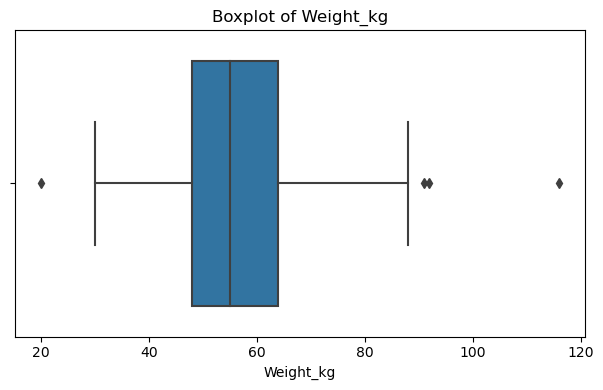

Initial class distribution:
Counter({'No': 164, 'Yes': 46})


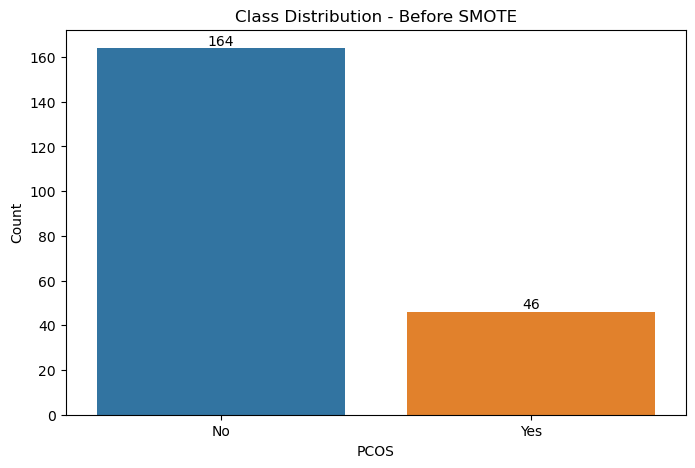


Final training set class distribution:
Counter({'Yes': 131, 'No': 131})


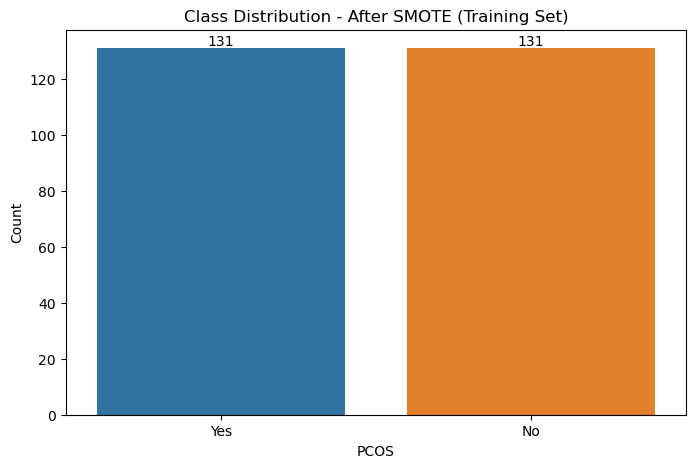


Validation set class distribution:
Counter({'No': 33, 'Yes': 9})


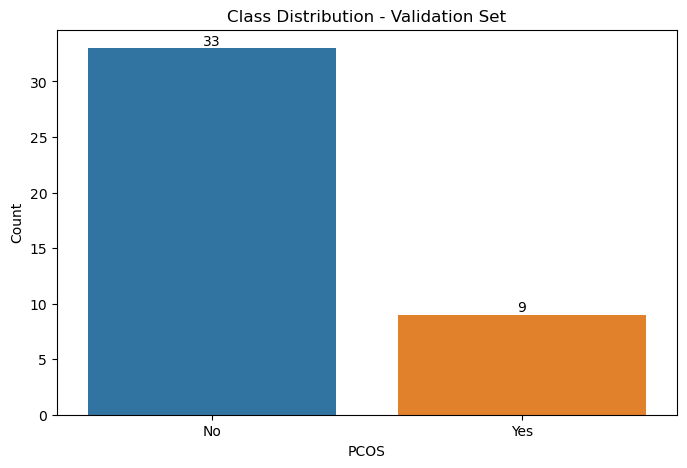


Data shapes after balancing:
Training features shape: (262, 42)
Training target shape: (262,)
Validation features shape: (42, 42)
Validation target shape: (42,)


In [10]:
# Load data
df_train, df_test, df_submission, df_original = load_data()

# Define features
features_numeric, features_categorical, target = define_features()

# Process age groups
df_train = process_age_groups(df_train)
df_test = process_age_groups(df_test, is_train=False)

# Process exercise types
df_train = process_exercise_types(df_train)
df_test = process_exercise_types(df_test, is_train=False)

# Update feature list
features_categorical.extend(['Age_Group', 'Exercise_Type_Clean'])
features_categorical.remove('Age')
features_categorical.remove('Exercise_Type')

# PREPARE DATA
df_train_prepared, df_test_prepared, encoders = prepare_data_for_modeling(df_train, df_test)

# FEATURE ENGINEERING
df_train_prepared = feature_engineering(df_train_prepared)
df_test_prepared = feature_engineering(df_test_prepared)

from collections import Counter
# Apply SMOTE and split data
X_train, X_val, y_train, y_val = balance_and_split_data(
    df_train_prepared,
    target_column='PCOS',
    test_size=0.2,
    random_state=42
)

print("\nData shapes after balancing:")
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation target shape: {y_val.shape}")


In [11]:

# Train and evaluate multiple models
print('===   STEP1 : TRAIN AND EVALUATE MODELS (KFOLD)   ===')
models, avg_metrics, scaler = train_and_evaluate_models_kfold(X_train, y_train, n_splits=5)

# Select the best model
print('===   STEP2 : SELECT THE BEST MODEL   ===')
best_model_name, best_model = select_best_model(models, avg_metrics)

# Perform hyperparameter optimization on the best model
print('===   STEP3 : HYPERPARAMETER OPTIMIZATION (BEST MODEL)   ===')
y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
best_model = optimize_best_model(X_train, y_train, best_model_name)

# Evaluate the tuned model on the validation set
print('===   STEP4 : EVALUATE THE TUNED MODEL ON VALIDATION DATASET   ===')
y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred_proba_val)
print(f"Validation AUC-ROC after hyperparameter tuning: {val_auc:.4f}")

# Prepare test predictions using the best model
print('===   STEP5 : GET PREDICTIONS ON TEST DATASET (BEST TUNED MODEL)   ===')
test_predictions = prepare_test_predictions(best_model, scaler, df_test_prepared, True)

===   STEP1 : TRAIN AND EVALUATE MODELS (KFOLD)   ===

Fold 1/5
Training Logistic Regression...
Logistic Regression Fold 1 AUC-ROC: 0.9698
Training Random Forest...
Random Forest Fold 1 AUC-ROC: 0.9720
Training XGBoost...
XGBoost Fold 1 AUC-ROC: 0.9698
Training LightGBM...
LightGBM Fold 1 AUC-ROC: 0.9670
Training CatBoost...
CatBoost Fold 1 AUC-ROC: 0.9698
Training SVM...
SVM Fold 1 AUC-ROC: 0.9799
Training KNN...
KNN Fold 1 AUC-ROC: 0.9626
Training Gradient Boosting...
Gradient Boosting Fold 1 AUC-ROC: 0.9540
Training AdaBoost...
AdaBoost Fold 1 AUC-ROC: 0.9382
Training MLP Neural Network...


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Neural Network Fold 1 AUC-ROC: 0.9871

Fold 2/5
Training Logistic Regression...
Logistic Regression Fold 2 AUC-ROC: 0.9672
Training Random Forest...
Random Forest Fold 2 AUC-ROC: 0.9900
Training XGBoost...
XGBoost Fold 2 AUC-ROC: 0.9900
Training LightGBM...
LightGBM Fold 2 AUC-ROC: 0.9915
Training CatBoost...
CatBoost Fold 2 AUC-ROC: 0.9900
Training SVM...
SVM Fold 2 AUC-ROC: 0.9687
Training KNN...
KNN Fold 2 AUC-ROC: 0.9088
Training Gradient Boosting...
Gradient Boosting Fold 2 AUC-ROC: 0.9701
Training AdaBoost...
AdaBoost Fold 2 AUC-ROC: 0.9672
Training MLP Neural Network...


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Neural Network Fold 2 AUC-ROC: 0.9573

Fold 3/5
Training Logistic Regression...
Logistic Regression Fold 3 AUC-ROC: 0.8521
Training Random Forest...
Random Forest Fold 3 AUC-ROC: 0.9564
Training XGBoost...
XGBoost Fold 3 AUC-ROC: 0.9911
Training LightGBM...
LightGBM Fold 3 AUC-ROC: 0.9660
Training CatBoost...
CatBoost Fold 3 AUC-ROC: 0.9778
Training SVM...
SVM Fold 3 AUC-ROC: 0.9601
Training KNN...
KNN Fold 3 AUC-ROC: 0.8698
Training Gradient Boosting...
Gradient Boosting Fold 3 AUC-ROC: 0.9379
Training AdaBoost...
AdaBoost Fold 3 AUC-ROC: 0.9112
Training MLP Neural Network...


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Neural Network Fold 3 AUC-ROC: 0.9098

Fold 4/5
Training Logistic Regression...
Logistic Regression Fold 4 AUC-ROC: 0.8979
Training Random Forest...
Random Forest Fold 4 AUC-ROC: 0.9290
Training XGBoost...
XGBoost Fold 4 AUC-ROC: 0.9630
Training LightGBM...
LightGBM Fold 4 AUC-ROC: 0.9482
Training CatBoost...
CatBoost Fold 4 AUC-ROC: 0.9512
Training SVM...
SVM Fold 4 AUC-ROC: 0.8950
Training KNN...
KNN Fold 4 AUC-ROC: 0.8646
Training Gradient Boosting...
Gradient Boosting Fold 4 AUC-ROC: 0.9290
Training AdaBoost...
AdaBoost Fold 4 AUC-ROC: 0.9275
Training MLP Neural Network...


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Neural Network Fold 4 AUC-ROC: 0.9024

Fold 5/5
Training Logistic Regression...
Logistic Regression Fold 5 AUC-ROC: 0.9643
Training Random Forest...
Random Forest Fold 5 AUC-ROC: 0.9717
Training XGBoost...
XGBoost Fold 5 AUC-ROC: 0.9732
Training LightGBM...
LightGBM Fold 5 AUC-ROC: 0.9688
Training CatBoost...
CatBoost Fold 5 AUC-ROC: 0.9851
Training SVM...
SVM Fold 5 AUC-ROC: 0.9598
Training KNN...
KNN Fold 5 AUC-ROC: 0.9464
Training Gradient Boosting...
Gradient Boosting Fold 5 AUC-ROC: 0.9539
Training AdaBoost...
AdaBoost Fold 5 AUC-ROC: 0.9598
Training MLP Neural Network...


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2025-02-03 15:13:58,337] A new study created in memory with name: no-name-5b45ae32-13cf-4e76-a3d1-790a34f46d8d


MLP Neural Network Fold 5 AUC-ROC: 0.9717
Average AUC-ROC for Logistic Regression: 0.9303
Average AUC-ROC for Random Forest: 0.9638
Average AUC-ROC for XGBoost: 0.9774
Average AUC-ROC for LightGBM: 0.9683
Average AUC-ROC for CatBoost: 0.9748
Average AUC-ROC for SVM: 0.9527
Average AUC-ROC for KNN: 0.9105
Average AUC-ROC for Gradient Boosting: 0.9490
Average AUC-ROC for AdaBoost: 0.9408
Average AUC-ROC for MLP Neural Network: 0.9456
===   STEP2 : SELECT THE BEST MODEL   ===

Best Model: XGBoost with Average Validation AUC-ROC: 0.9774
===   STEP3 : HYPERPARAMETER OPTIMIZATION (BEST MODEL)   ===


[I 2025-02-03 15:14:01,735] Trial 0 finished with value: 0.9418474687705457 and parameters: {'n_estimators': 359, 'max_depth': 4, 'learning_rate': 0.2813251372524279, 'subsample': 0.5094114686683636, 'colsample_bytree': 0.7133276449169785, 'gamma': 0.6315653765299675, 'min_child_weight': 4}. Best is trial 0 with value: 0.9418474687705457.
[I 2025-02-03 15:14:02,831] Trial 1 finished with value: 0.924490466798159 and parameters: {'n_estimators': 106, 'max_depth': 9, 'learning_rate': 0.19033278502835874, 'subsample': 0.6281705788620515, 'colsample_bytree': 0.8542722189334735, 'gamma': 0.4154396856845517, 'min_child_weight': 10}. Best is trial 0 with value: 0.9418474687705457.
[I 2025-02-03 15:14:04,619] Trial 2 finished with value: 0.9588319088319089 and parameters: {'n_estimators': 154, 'max_depth': 4, 'learning_rate': 0.07266433210153773, 'subsample': 0.9980317776433892, 'colsample_bytree': 0.8834752906924949, 'gamma': 0.7952099481894829, 'min_child_weight': 4}. Best is trial 2 with va

Best hyperparameters found: {'n_estimators': 383, 'max_depth': 5, 'learning_rate': 0.1091722316673479, 'subsample': 0.8284208820701027, 'colsample_bytree': 0.997790828035102, 'gamma': 0.046635419869156126, 'min_child_weight': 2}
===   STEP4 : EVALUATE THE TUNED MODEL ON VALIDATION DATASET   ===
Validation AUC-ROC after hyperparameter tuning: 0.7778
===   STEP5 : GET PREDICTIONS ON TEST DATASET (BEST TUNED MODEL)   ===

Submission file created: submission.csv
